# CS675 Midterm Project - 
Kaggle Competition - House Prices Prediction


Project Team:

<li>Ahamed Arafaath Muthalif Mubarak Ali</li>
<li>Sebastian Fine</li>
<li>Sajin Shajee</li>
<li>Rohit Subramaniam</li>

# <u>Load the dataset</u>

In [141]:
#Imported Packages:

#Generic
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data Modeling
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Data Processing
from sklearn.preprocessing import LabelEncoder

#Linear Regression
from sklearn.linear_model import LinearRegression

#Support Vector Regressor
from sklearn.svm import SVR

#Decision Tree
from sklearn.tree import DecisionTreeRegressor

#Random forest classifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#Data Visualization
from scipy.stats import iqr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Function
***get_cat_num_features***
<ol>
    <li>Input: Dataframe</li>
    <li>Process: Creates two matrices: num_features, cat_features</li>
    <li>Returns: num_features for data types float64 or int64</li>
    <li>Returns: cat_features for all othre data types</li>
</ol>

In [142]:
def get_cat_num_features(df):
    num_features = []
    cat_features = []
    for col in df.columns:
        if df[col].dtype=="float64" or df[col].dtype=="int64":
            num_features.append(col)
        else:
            cat_features.append(col)
    return num_features, cat_features

## Function
***get_outliers***
<ol>
    <li>Input: Dataframe, number of dataframe features (num_feat)</li>
    <li>Process: Creates outlier_df dataframe with 4 columns</li>
    <li>Returns: outlier_df with upper and lower outlier boundaries (3 standard deviations)</li>
</ol>

In [143]:
def get_outliers(df, num_feat):
    outlier_df = pd.DataFrame(columns=['Feature', 'Total Outliers','Upper limit', 'Lower limit'])
    for col in num_feat:      
        lower = df[col].mean() - df[col].std() * 3
        upper = df[col].mean() + df[col].std() * 3
#         lower=np.percentile(df[col],25)-(1.5*iqr(df[col]))
#         upper=np.percentile(df[col],75)+(1.5*iqr(df[col]))
        upper_outliers = df[df[col] > upper]
        lower_outliers = df[df[col] < lower]
        total=lower_outliers.shape[0]+upper_outliers.shape[0]
        if (total!=0) and (upper!=0 and lower!=0):
            outlier_df = outlier_df.append({'Feature':col, 'Total Outliers': total,'Upper limit': upper, 'Lower limit':lower}, ignore_index=True)
    return outlier_df

## Function
***remove_outliers***
<ol>
    <li>Input: Dataframe, outlier identification dataframe (outlier_df), number of dataframe features (num_feat)</li>
    <li>Process: Replaces identified outliers with the median of the data for each column </li>
    <li>Returns: Modified dataframe</li>
</ol>

In [144]:
def remove_outliers(df, outlier_df, num_feat):
    for col in outlier_df['Feature'].to_list():
        upper = outlier_df[outlier_df['Feature']== col ]['Upper limit'].values[0]
        lower = outlier_df[outlier_df['Feature']== col ]['Lower limit'].values[0]
        df[col] = np.where((df[col]<lower)|(df[col]>upper), df[col].median(), df[col])
    return df

In [145]:
#Imported the dataset
data=pd.read_csv('train.csv', index_col='Id')
data2=pd.read_csv('test.csv', index_col='Id')
temp=data['SalePrice'] #Isolated
data=data.drop(['SalePrice'],axis=1)
data=pd.concat([data,data2])

In [146]:
data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml


In [147]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# <u>Exploratory Data Analysis</u> 

In [148]:
# Check for number of null values
nulls = data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

MSZoning 4
LotFrontage 486
Alley 2721
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 24
MasVnrArea 23
BsmtQual 81
BsmtCond 82
BsmtExposure 82
BsmtFinType1 79
BsmtFinSF1 1
BsmtFinType2 80
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
Electrical 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 1420
GarageType 157
GarageYrBlt 159
GarageFinish 159
GarageCars 1
GarageArea 1
GarageQual 159
GarageCond 159
PoolQC 2909
Fence 2348
MiscFeature 2814
SaleType 1


### Handling missing data and different data types

In [149]:
data=data.fillna({'Alley':'NA','BsmtQual':'NA','BsmtCond':'NA','BsmtExposure':'NA','BsmtFinType1':'NA',
                  'BsmtFinType2':'NA','FireplaceQu':'NA','GarageType':'NA','GarageFinish':'NA','GarageQual':'NA',
                  'GarageCond':'NA','PoolQC':'NA','Fence':'NA','MiscFeature':'NA','Exterior2nd':'NA',
                  'Functional':'Typ'})
cate=['MSZoning','Exterior1st','MasVnrType','Electrical','KitchenQual','Functional','GarageYrBlt','SaleType']
for item in cate:
    data[item]=data[item].fillna(data[item].value_counts().index[0])
    
data=data.drop(['Utilities'],axis=1)
data=data.drop(['KitchenAbvGr'],axis=1)
tem=np.where(data['MasVnrType']=='None',0,data['MasVnrArea'])
data['MasVnrArea']=data['MasVnrArea'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType1']=='NA',0,data['BsmtFinSF1'])
data['BsmtFinSF1']=data['BsmtFinSF1'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType2']=='NA',0,data['BsmtFinSF2'])
data['BsmtFinSF2']=data['BsmtFinSF2'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtUnfSF'])
data['BsmtUnfSF']=data['BsmtUnfSF'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtHalfBath'])
data['BsmtHalfBath']=data['BsmtHalfBath'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtFullBath'])
data['BsmtFullBath']=data['BsmtFullBath'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageCars'])
data['GarageCars']=data['GarageCars'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageArea'])
data['GarageArea']=data['GarageArea'].fillna(pd.Series(tem))
data['LotFrontage']=data.groupby('Neighborhood')["LotFrontage"].transform(lambda x: x.fillna(x.median()))

data['TotalBsmtSF']=(data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF'])
data['TotalSF']=data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
data['Total_sqr_footage'] = (data['BsmtFinSF1']+data['BsmtFinSF2']+data['1stFlrSF']+data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath'])+data['BsmtFullBath']+(0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF']+data['3SsnPorch']+data['EnclosedPorch'] + data['ScreenPorch']
                          +data['WoodDeckSF'])
data=data.drop(columns=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','2ndFlrSF','FullBath','HalfBath','BsmtFullBath',
                        'BsmtHalfBath','OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF'])
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)
tem=np.where(data['YrSold']>data['GarageYrBlt'],data['YrSold'],np.where(data['GarageYrBlt']>data['YearRemodAdd'],
                                                                        data['GarageYrBlt'],data['YearRemodAdd']))
data['age']=tem-data['YearBuilt']
data['YearRemodAdd']=data['YearRemodAdd'].astype(str)
data['YearBuilt']=data['YearBuilt'].astype(str)
data['GarageYrBlt']=data['GarageYrBlt'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
od=['MSZoning','LotShape','LandContour','LandSlope','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond',
    'BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
    'FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence','MiscFeature',
    'SaleType','SaleCondition']
dm=['MSSubClass','Street','Alley','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
    'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation','Heating']
data=pd.get_dummies(data,columns=dm)
num_feat,cat_feat=get_cat_num_features(data)

The above code converts all the NaN values to either 0 for numerical variable or NA for categorical/ordinal variable.


The above code block also converts all the categorical variables to dummy variable i.e., it creates a new series of columns for every value in categorical variable columns and changes them to 1 and 0 depending on their respective rows. 

#### Following features are created:
<li>Age: Which the sale year subtracted from house construction year - This features gives an estimate of the age of the house when it was sold and how does age factor affect the sale price of the house</li>
<li>TotalSF: Which is the total square feet of the entire building including basement, ground floor and first floor - This feature gives an idea of how the area would affect the sale price of the house</li>
<li>Total Bathrooms: Which is the total number of bathrooms including full and half bathrooms in all the floors - This features gives an idea of does number of bathroom in any way affect the sale price of the house</li>
<li>Total_poarch_sf: Whcih is the total square feet all the poarch area in the house - This feature gives an idea of does the parch size matter with respect to sale price</li>
<li>TotalBsmtSF: Which is the total square feet of basement including finsihed and unfinished area - This feature gives an idea of does the basement size affect the sale price</li>

In [150]:
# Standardize the data based on their z-score
std_df = data[num_feat]
std_df

,LotFrontage,LotArea,OverallQual,MasVnrArea,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,age
Id,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,196.0,856.0,856,0,1710,3,8,0,2.0,548.0,0,0,2566.0,2416.0,3.5,61,5.0
2,80.0,9600,6,0.0,1262.0,1262,0,1262,3,6,1,2.0,460.0,0,0,2524.0,2240.0,2.5,298,31.0
3,68.0,11250,7,162.0,920.0,920,0,1786,3,6,1,2.0,608.0,0,0,2706.0,2272.0,3.5,42,7.0
4,60.0,9550,7,0.0,756.0,961,0,1717,3,7,1,3.0,642.0,0,0,2473.0,1933.0,2.0,307,91.0
5,84.0,14260,8,350.0,1145.0,1145,0,2198,4,9,1,3.0,836.0,0,0,3343.0,2853.0,3.5,276,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,21.0,1936,4,0.0,546.0,546,0,1092,3,5,0,0.0,0.0,0,0,1638.0,1092.0,1.5,0,36.0
2916,21.0,1894,4,0.0,546.0,546,0,1092,3,6,0,1.0,286.0,0,0,1638.0,1344.0,1.5,24,36.0
2917,160.0,20000,5,0.0,1224.0,1224,0,1224,4,7,1,2.0,576.0,0,0,2448.0,2448.0,2.0,474,46.0


In [151]:
# Standardize the data based on their z-score
for stdCol in std_df.columns:
    std_df[stdCol] = (std_df[stdCol] - std_df[stdCol].mean()) / (std_df[stdCol].mean())

In [152]:
std_df.head()

,LotFrontage,LotArea,OverallQual,MasVnrArea,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,age
Id,,,,,,,,,,,,,,,,,,,,
1,-0.065326,-0.168971,0.149601,0.923985,-0.186048,-0.261803,-1.0,0.139423,0.048868,0.240017,-1.000000,0.132273,0.159183,-1.0,-1.0,0.007174,0.215946,0.577594,-0.666593,-0.863201
2,0.150367,-0.055872,-0.014628,-1.000000,0.200009,0.088323,-1.0,-0.159093,0.048868,-0.069987,0.674699,0.132273,-0.026963,-1.0,-1.0,-0.009312,0.127367,0.126853,0.628775,-0.151843
3,-0.022188,0.106400,0.149601,0.590233,-0.125191,-0.206610,-1.0,0.190064,0.048868,-0.069987,0.674699,0.132273,0.286101,-1.0,-1.0,0.062125,0.143473,0.577594,-0.770441,-0.808481
4,-0.137224,-0.060789,0.149601,-1.000000,-0.281135,-0.171253,-1.0,0.144087,0.048868,0.085015,0.674699,0.698410,0.358021,-1.0,-1.0,-0.029330,-0.027142,-0.098518,0.677966,1.489751
5,0.207886,0.402423,0.313829,2.435688,0.088757,-0.012575,-1.0,0.464591,0.398491,0.395019,0.674699,0.698410,0.768388,-1.0,-1.0,0.312152,0.435883,0.577594,0.508530,-0.781121


In [153]:
#Merge the standardized data with remaining categorical and ordinal data
data = data.drop(columns = num_feat)
data = pd.concat([data,std_df],axis=1)

# <u>Pre-Outlier Removal Data Shape and Description</u>

* The shape (skewness) and description of each data column <u><b>PRIOR</b></u> to entering outlier detection and removal are described below. 

Skewness: 1.5064780938156954
count    2.919000e+03
mean     1.550376e-17
std      3.120840e-01
min     -6.980285e-01
25%     -1.372244e-01
50%      6.571558e-03
75%      1.503675e-01
max      3.500813e+00
Name: LotFrontage, dtype: float64


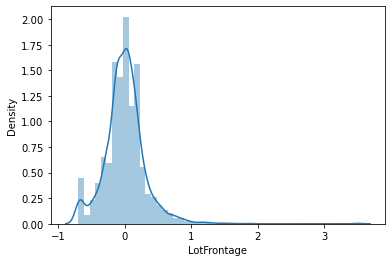

Skewness: 12.829024853018764
count    2.919000e+03
mean    -1.041904e-17
std      7.756597e-01
min     -8.721493e-01
25%     -2.645637e-01
50%     -7.032908e-02
75%      1.378708e-01
max      2.016863e+01
Name: LotArea, dtype: float64


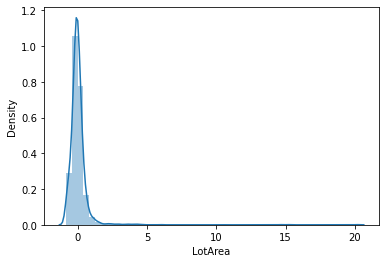

Skewness: 0.19721180528040175
count    2.919000e+03
mean    -8.953289e-17
std      2.315537e-01
min     -8.357714e-01
25%     -1.788568e-01
50%     -1.462811e-02
75%      1.496005e-01
max      6.422865e-01
Name: OverallQual, dtype: float64


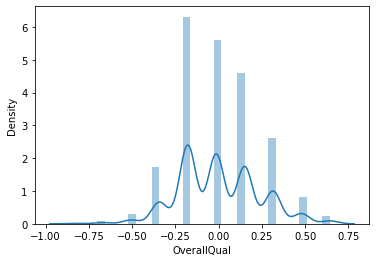

Skewness: 2.604366959260798
count    2.919000e+03
mean    -8.271998e-17
std      1.758249e+00
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%      6.098654e-01
max      1.470600e+01
Name: MasVnrArea, dtype: float64


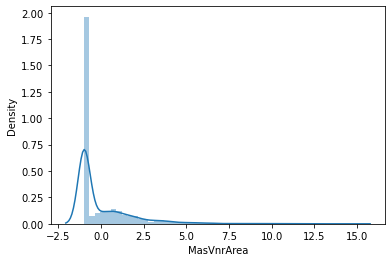

Skewness: 1.1633524315458459
count    2.919000e+03
mean    -3.274521e-17
std      4.190883e-01
min     -1.000000e+00
25%     -2.459529e-01
50%     -5.958060e-02
75%      2.380445e-01
max      4.809871e+00
Name: TotalBsmtSF, dtype: float64


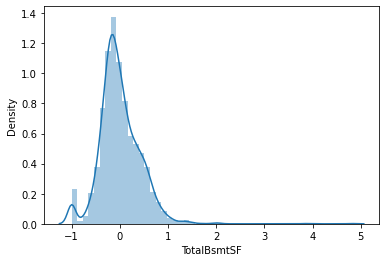

Skewness: 1.470360105537923
count    2.919000e+03
mean    -5.436061e-17
std      3.383652e-01
min     -7.119651e-01
25%     -2.445552e-01
50%     -6.690491e-02
75%      1.965522e-01
max      3.393826e+00
Name: 1stFlrSF, dtype: float64


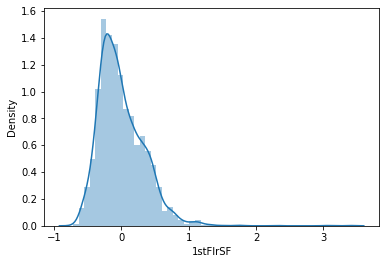

Skewness: 12.094977192517305
count    2.919000e+03
mean     1.022364e-16
std      9.883407e+00
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      2.256523e+02
Name: LowQualFinSF, dtype: float64


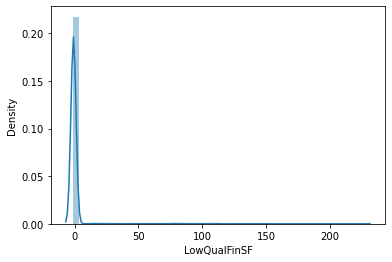

Skewness: 1.2700104075191505
count    2.919000e+03
mean     3.025633e-17
std      3.371966e-01
min     -7.774461e-01
25%     -2.497134e-01
50%     -3.782074e-02
75%      1.617448e-01
max      2.759429e+00
Name: GrLivArea, dtype: float64


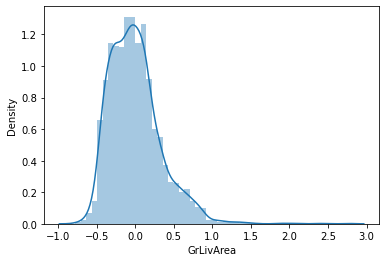

Skewness: 0.3264921492707987
count    2.919000e+03
mean     9.210021e-17
std      2.876322e-01
min     -1.000000e+00
25%     -3.007546e-01
50%      4.886813e-02
75%      4.886813e-02
max      1.796982e+00
Name: BedroomAbvGr, dtype: float64


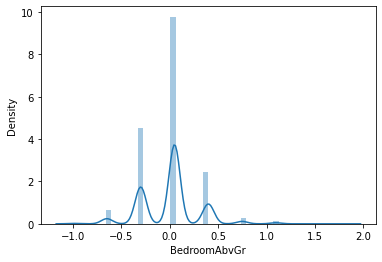

Skewness: 0.7587568676624693
count    2.919000e+03
mean     7.102917e-17
std      2.432571e-01
min     -6.899958e-01
25%     -2.249894e-01
50%     -6.998726e-02
75%      8.501487e-02
max      1.325032e+00
Name: TotRmsAbvGrd, dtype: float64


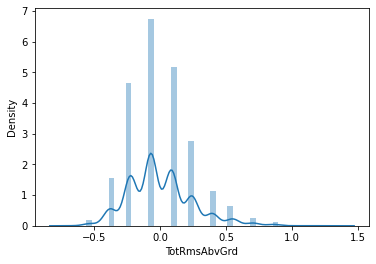

Skewness: 0.7338717708781026
count    2.919000e+03
mean     4.398294e-16
std      1.082072e+00
min     -1.000000e+00
25%     -1.000000e+00
50%      6.746988e-01
75%      6.746988e-01
max      5.698795e+00
Name: Fireplaces, dtype: float64


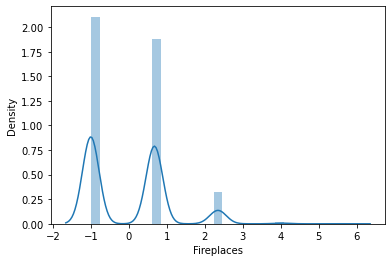

Skewness: -0.21761096872117058
count    2.919000e+03
mean    -2.472234e-17
std      4.311843e-01
min     -1.000000e+00
25%     -4.338635e-01
50%      1.322731e-01
75%      1.322731e-01
max      1.830683e+00
Name: GarageCars, dtype: float64


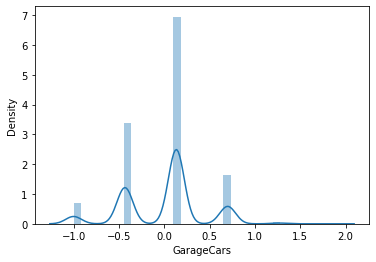

Skewness: 0.2409730243544972
count    2.919000e+03
mean     3.972689e-17
std      4.557798e-01
min     -1.000000e+00
25%     -3.231049e-01
50%      1.534261e-02
75%      2.184111e-01
max      2.147562e+00
Name: GarageArea, dtype: float64


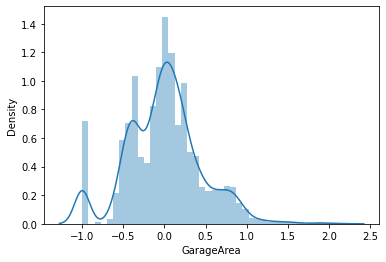

Skewness: 16.9070172435751
count    2.919000e+03
mean    -3.894719e-17
std      1.583798e+01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      3.542716e+02
Name: PoolArea, dtype: float64


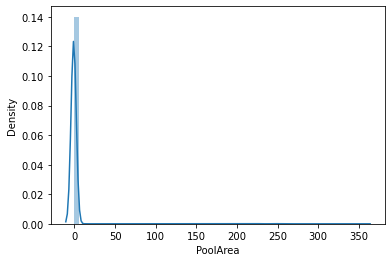

Skewness: 21.958480324447216
count    2.919000e+03
mean    -3.468734e-17
std      1.116363e+01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      3.334747e+02
Name: MiscVal, dtype: float64


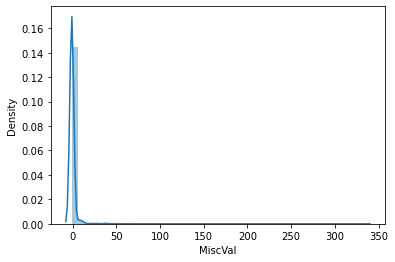

Skewness: 1.5159576437313693
count    2.919000e+03
mean    -7.729533e-17
std      3.158628e-01
min     -8.689026e-01
25%     -2.149856e-01
50%     -3.914234e-02
75%      1.741853e-01
max      3.612745e+00
Name: TotalSF, dtype: float64


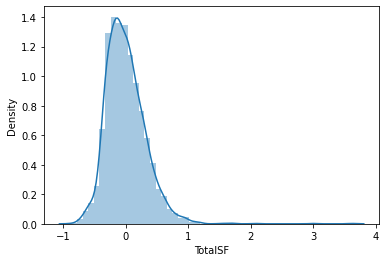

Skewness: 1.8357526169142555
count    2.919000e+03
mean     8.291491e-18
std      3.829420e-01
min     -8.319015e-01
25%     -2.516093e-01
50%     -6.992199e-02
75%      1.963179e-01
max      4.680119e+00
Name: Total_sqr_footage, dtype: float64


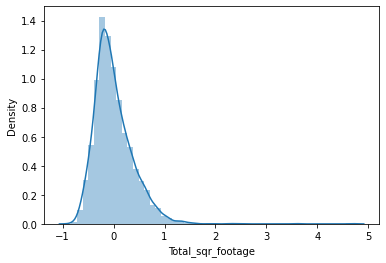

Skewness: 0.4931718915072795
count    2.919000e+03
mean     4.316900e-17
std      3.644852e-01
min     -5.492588e-01
25%     -3.238882e-01
50%     -9.851760e-02
75%      1.268530e-01
max      2.155188e+00
Name: Total_Bathrooms, dtype: float64


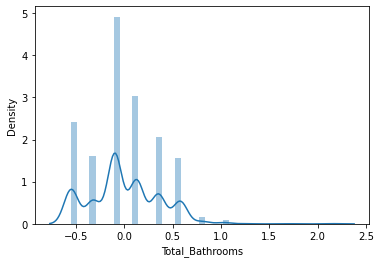

Skewness: 1.3773569233370029
count    2.919000e+03
mean    -3.116916e-17
std      8.746271e-01
min     -1.000000e+00
25%     -7.376470e-01
50%     -1.036271e-01
75%      4.566059e-01
max      6.783140e+00
Name: Total_porch_sf, dtype: float64


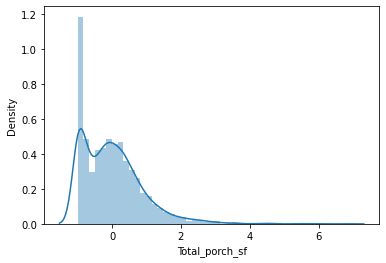

Skewness: 0.6382633049371135
count    2.919000e+03
mean     3.183476e-17
std      8.339268e-01
min     -1.000000e+00
25%     -8.084807e-01
50%     -4.240362e-02
75%      5.047943e-01
max      4.499339e+00
Name: age, dtype: float64


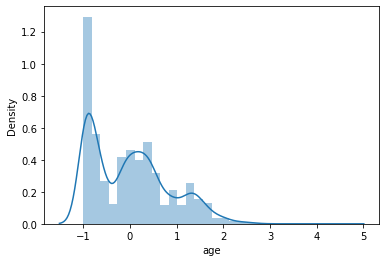

In [154]:
#Pre-Selection Data Descriptions
for col in num_feat:
    plt.tight_layout()
    sns.distplot(data[col])
    print("Skewness: "+str(data[col].skew()))
    print(data[col].describe())
    plt.show()

## Outlier Removal and Detection

In [155]:
#Handle the outlier by applying the function created above
outlier_df = get_outliers(data, num_feat)
data=remove_outliers(data,outlier_df,num_feat)

# <u>Post-Outlier Removal Data Shape and Description</u>

* The shape (skewness) and description of each data column <u><b>AFTER</b></u> entering outlier detection and removal are described below. 

Skewness: 0.06292101350706521
count    2919.000000
mean       -0.012552
std         0.274981
min        -0.698029
25%        -0.137224
50%         0.006572
75%         0.150367
max         0.926866
Name: LotFrontage, dtype: float64


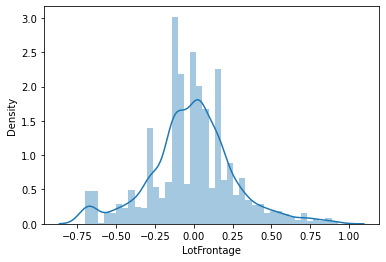

Skewness: 1.0708901383043925
count    2919.000000
mean       -0.052088
std         0.391214
min        -0.872149
25%        -0.264564
50%        -0.070329
75%         0.123512
max         2.257241
Name: LotArea, dtype: float64


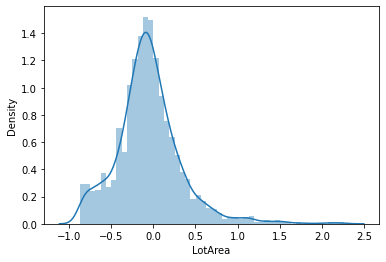

Skewness: 0.25417160571968045
count    2919.000000
mean        0.001125
std         0.229475
min        -0.671543
25%        -0.178857
50%        -0.014628
75%         0.149601
max         0.642286
Name: OverallQual, dtype: float64


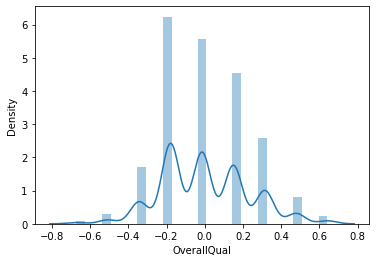

Skewness: 1.7321823398064846
count    2919.000000
mean       -0.180129
std         1.350033
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         0.413540
max         5.223504
Name: MasVnrArea, dtype: float64


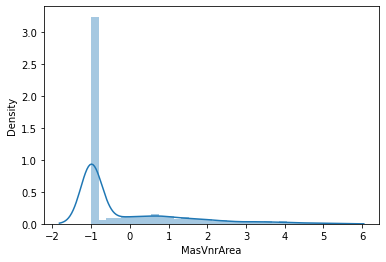

Skewness: 0.1482145718891874
count    2919.000000
mean       -0.013345
std         0.383154
min        -1.000000
25%        -0.245953
50%        -0.059581
75%         0.224732
max         1.215548
Name: TotalBsmtSF, dtype: float64


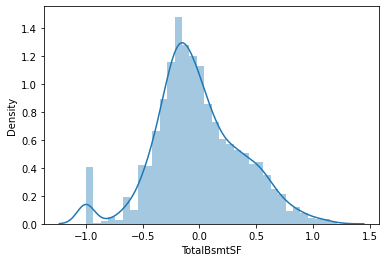

Skewness: 0.6014241233072075
count    2919.000000
mean       -0.014388
std         0.303544
min        -0.711965
25%        -0.244555
50%        -0.066905
75%         0.181461
max         0.974850
Name: 1stFlrSF, dtype: float64


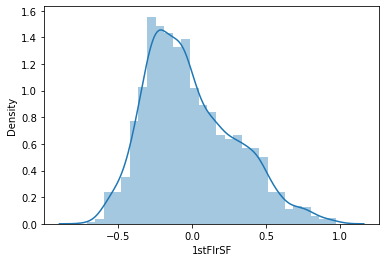

Skewness: 19.72325142259771
count    2919.000000
mean       -0.937605
std         1.161936
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        28.822667
Name: LowQualFinSF, dtype: float64


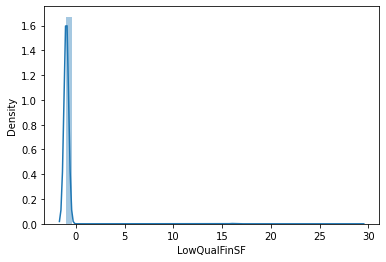

Skewness: 0.6561882864628314
count    2919.000000
mean       -0.012510
std         0.307424
min        -0.777446
25%        -0.249713
50%        -0.037821
75%         0.153749
max         1.002319
Name: GrLivArea, dtype: float64


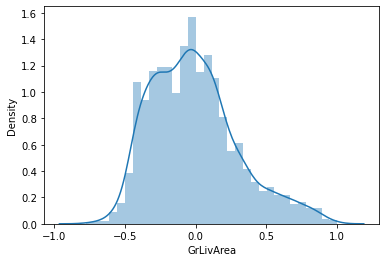

Skewness: 0.005842119416639227
count    2919.000000
mean       -0.005270
std         0.264969
min        -0.650377
25%        -0.300755
50%         0.048868
75%         0.048868
max         0.748114
Name: BedroomAbvGr, dtype: float64


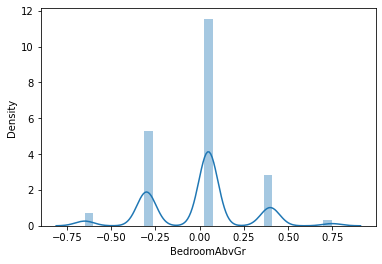

Skewness: 0.5427154472799438
count    2919.000000
mean       -0.006372
std         0.231702
min        -0.689996
25%        -0.224989
50%        -0.069987
75%         0.085015
max         0.705023
Name: TotRmsAbvGrd, dtype: float64


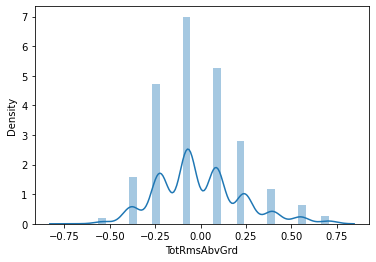

Skewness: 0.579723593111578
count    2919.000000
mean       -0.014343
std         1.048986
min        -1.000000
25%        -1.000000
50%         0.674699
75%         0.674699
max         2.349398
Name: Fireplaces, dtype: float64


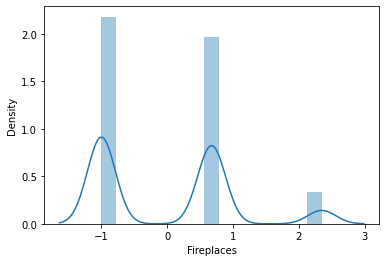

Skewness: -0.24204934779630696
count    2919.000000
mean       -0.000582
std         0.429857
min        -1.000000
25%        -0.433863
50%         0.132273
75%         0.132273
max         1.264546
Name: GarageCars, dtype: float64


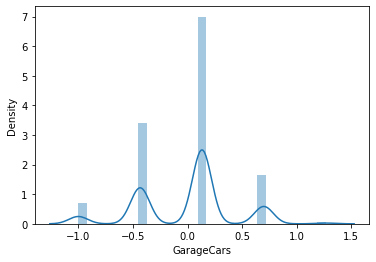

Skewness: 0.005716671333850392
count    2919.000000
mean       -0.009532
std         0.437547
min        -1.000000
25%        -0.323105
50%         0.015343
75%         0.218411
max         1.347980
Name: GarageArea, dtype: float64


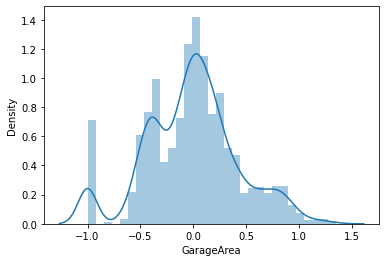

Skewness: 0
count    2919.0
mean       -1.0
std         0.0
min        -1.0
25%        -1.0
50%        -1.0
75%        -1.0
max        -1.0
Name: PoolArea, dtype: float64


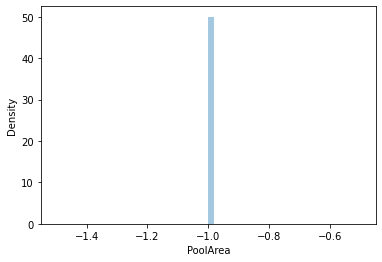

Skewness: 8.131975481170493
count    2919.000000
mean       -0.655833
std         2.250959
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        28.748573
Name: MiscVal, dtype: float64


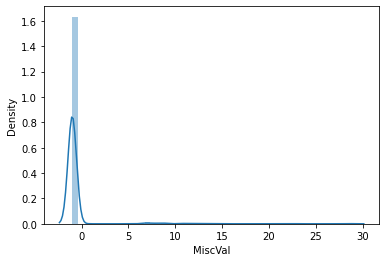

Skewness: 0.4817141697690437
count    2919.000000
mean       -0.010321
std         0.286759
min        -0.868903
25%        -0.214986
50%        -0.039142
75%         0.168101
max         0.946051
Name: TotalSF, dtype: float64


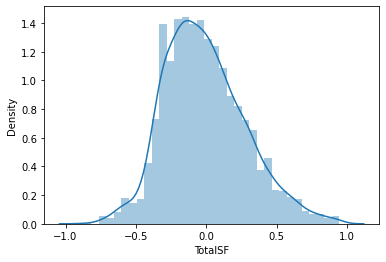

Skewness: 0.7249021940308484
count    2919.000000
mean       -0.014452
std         0.342821
min        -0.831901
25%        -0.251609
50%        -0.069922
75%         0.181471
max         1.129919
Name: Total_sqr_footage, dtype: float64


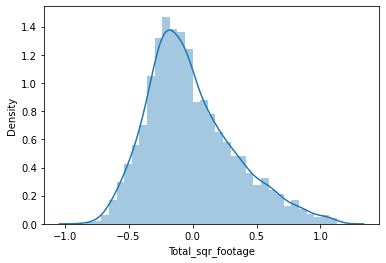

Skewness: 0.22776236099457348
count    2919.000000
mean       -0.004941
std         0.352802
min        -0.549259
25%        -0.323888
50%        -0.098518
75%         0.126853
max         1.028335
Name: Total_Bathrooms, dtype: float64


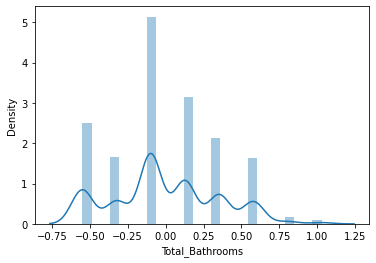

Skewness: 0.7482752481241164
count    2919.000000
mean       -0.044171
std         0.776537
min        -1.000000
25%        -0.737647
50%        -0.103627
75%         0.423812
max         2.601889
Name: Total_porch_sf, dtype: float64


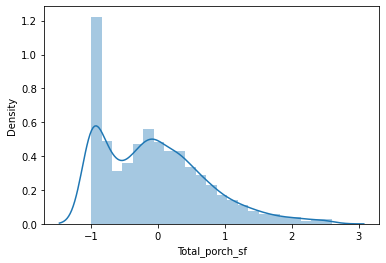

Skewness: 0.57289392977156
count    2919.000000
mean       -0.006945
std         0.821433
min        -1.000000
25%        -0.808481
50%        -0.042404
75%         0.477434
max         2.474707
Name: age, dtype: float64


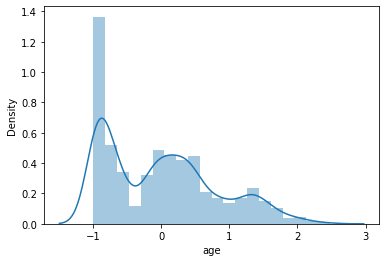

In [156]:
#Post-Outlier Removal Data Descriptions
for col in num_feat:
    plt.tight_layout()
    sns.distplot(data[col])
    print("Skewness: "+str(data[col].skew()))
    print(data[col].describe())
    plt.show()

In [157]:
#Handle the oridnal variable by encoding them to numerical values
for col in data.select_dtypes('object').columns:
    if col in od:
        le=LabelEncoder()
        data[col]=le.fit_transform(data[col])
    else:
        continue

**Note:**
Initialy for the EDA, we decided to merge the data and handle the missing values, outliers. Now for training, 
we will have to isolate both the columns again and train the model only of the train data and submit predictions using 
test data in to the Kaggle competition.

In [158]:
data2=data.iloc[1460:,:]
data=data.iloc[0:1460,:]
data=data.join(temp)
data.head(10)

,MSZoning,LotShape,LandContour,LandSlope,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,...,GarageCars,GarageArea,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,age,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,3,3,3,0,4,2003,2003,2,4,2,...,0.132273,0.159183,-1.0,-1.000000,0.007174,0.215946,0.577594,-0.666593,-0.863201,208500
2,3,3,3,0,7,1976,1976,3,4,2,...,0.132273,-0.026963,-1.0,-1.000000,-0.009312,0.127367,0.126853,0.628775,-0.151843,181500
3,3,0,3,0,4,2001,2002,2,4,2,...,0.132273,0.286101,-1.0,-1.000000,0.062125,0.143473,0.577594,-0.770441,-0.808481,223500
4,3,0,3,0,4,1915,1970,3,4,4,...,0.698410,0.358021,-1.0,-1.000000,-0.029330,-0.027142,-0.098518,0.677966,1.489751,140000
5,3,0,3,0,4,2000,2000,2,4,2,...,0.698410,0.768388,-1.0,-1.000000,0.312152,0.435883,0.577594,0.508530,-0.781121,250000
6,3,0,3,0,4,1993,1995,3,4,2,...,0.132273,0.015343,-1.0,12.772487,-0.152969,0.053887,0.126853,1.131618,-0.562242,143000
7,3,3,3,0,4,2004,2005,2,4,0,...,0.132273,0.345329,-1.0,-1.000000,0.326674,0.541574,0.352224,0.705295,-0.917920,307000
8,3,0,3,0,5,1973,1973,3,4,2,...,0.132273,0.023804,-1.0,5.886244,0.254846,0.500304,0.577594,-0.103627,-0.015044,200000
9,4,3,3,0,4,1931,1950,3,4,4,...,0.132273,-0.010041,-1.0,-1.000000,0.069975,-0.107165,-0.098518,0.612378,1.106712,129900


In [159]:
data.describe()

,MSZoning,LotShape,LandContour,LandSlope,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,GarageCars,GarageArea,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,age,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,3.028767,1.942466,2.777397,0.062329,4.575342,2.539726,3.733562,2.724658,3.691096,2.936986,...,0.000433,-0.007579,-1.0,-0.653747,-0.005028,-0.008279,-0.005745,-0.046679,-0.007304,180921.195890
std,0.632017,1.409156,0.707666,0.276232,1.112799,0.693995,0.731807,1.278630,0.949616,1.567797,...,0.423082,0.436349,0.0,2.172241,0.285262,0.343023,0.349641,0.782979,0.816199,79442.502883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.0,-1.000000,-0.868903,-0.831901,-0.549259,-1.000000,-1.000000,34900.000000
25%,3.000000,0.000000,3.000000,0.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000,...,-0.433863,-0.292433,-1.0,-1.000000,-0.211257,-0.248590,-0.098518,-0.754044,-0.781121,129975.000000
50%,3.000000,3.000000,3.000000,0.000000,4.000000,3.000000,4.000000,2.000000,4.000000,4.000000,...,0.132273,0.015343,-1.0,-1.000000,-0.035021,-0.066147,-0.098518,-0.103627,-0.042404,163000.000000
75%,3.000000,3.000000,3.000000,0.000000,5.000000,3.000000,4.000000,4.000000,4.000000,4.000000,...,0.132273,0.218411,-1.0,-1.000000,0.172812,0.188894,0.126853,0.422445,0.477434,214000.000000
max,4.000000,3.000000,3.000000,2.000000,8.000000,3.000000,4.000000,4.000000,4.000000,4.000000,...,1.264546,1.261253,-1.0,26.544975,0.934668,1.129919,1.028335,2.590957,2.474707,755000.000000


#### This variable contains the dataframe of features that has outliers, number of outliers in them and their upper/lower limit 

In [160]:
outlier_df 

,Feature,Total Outliers,Upper limit,Lower limit
0,LotFrontage,26,0.936252,-0.936252
1,LotArea,29,2.326979,-2.326979
2,OverallQual,4,0.694661,-0.694661
3,MasVnrArea,63,5.274746,-5.274746
4,TotalBsmtSF,21,1.257265,-1.257265
5,1stFlrSF,29,1.015096,-1.015096
6,LowQualFinSF,31,29.650222,-29.650222
7,GrLivArea,25,1.011590,-1.011590
8,BedroomAbvGr,30,0.862897,-0.862897
9,TotRmsAbvGrd,19,0.729771,-0.729771


## <u>Feature extraction based on feature importance</u>

In [161]:
rand = RandomForestRegressor(random_state=42, n_estimators=65)
rand.fit(data.drop('SalePrice',axis=1), data.SalePrice)
rand.feature_importances_

array([1.64158809e-03, 1.21103992e-03, 8.14305274e-04, 3.86165485e-04,
       6.03379337e-03, 4.78680274e-03, 1.24636917e-02, 2.50372378e-03,
       5.51590360e-04, 5.57217124e-03, 3.34816716e-04, 1.45494294e-03,
       1.08418238e-03, 1.36970181e-03, 5.91867352e-04, 2.00012382e-03,
       1.20125499e-04, 4.48452561e-03, 1.25178128e-03, 9.41791663e-04,
       1.97258641e-03, 3.94400303e-03, 1.14400231e-03, 4.03848399e-04,
       5.52606813e-04, 2.53684455e-04, 2.59250679e-03, 5.94264774e-04,
       1.79752144e-05, 3.59024961e-03, 1.53624783e-03, 1.06167643e-03,
       1.85718779e-03, 3.10138019e-05, 0.00000000e+00, 1.13769271e-04,
       5.45538083e-07, 1.63608427e-05, 2.88164052e-04, 1.31802317e-04,
       4.52278427e-07, 4.76238251e-06, 2.24464383e-04, 7.88853676e-04,
       1.21953689e-04, 1.41822497e-04, 4.93798119e-05, 3.16175798e-06,
       1.22786188e-04, 3.84345995e-07, 4.59077537e-06, 4.38948569e-05,
       4.80331535e-04, 3.75351332e-05, 3.55398387e-04, 7.14022573e-04,
      

In [162]:
dict(reversed(sorted(zip(rand.feature_importances_, data.columns.values))))

{0.5339643718661968: 'OverallQual',
 0.20043428559749327: 'TotalSF',
 0.058311099033376584: 'Total_sqr_footage',
 0.014687227846962457: 'GarageCars',
 0.013762044220402706: 'LotArea',
 0.012463691652679092: 'YearRemodAdd',
 0.01240346014167933: 'Total_Bathrooms',
 0.009871933714831707: 'GrLivArea',
 0.009227110572832419: 'GarageArea',
 0.008207820692030894: 'age',
 0.007686217152636184: 'TotalBsmtSF',
 0.007543567786175143: 'Neighborhood_NoRidge',
 0.007047107444848437: 'Total_porch_sf',
 0.00661977017669518: '1stFlrSF',
 0.006033793372242883: 'OverallCond',
 0.005572171244734693: 'BsmtQual',
 0.004786802737873512: 'YearBuilt',
 0.0046349798789447625: 'BedroomAbvGr',
 0.004531143958291537: 'LotFrontage',
 0.004484525613180939: 'KitchenQual',
 0.003944003028512088: 'GarageYrBlt',
 0.0035902496100813945: 'MoSold',
 0.0035137170513873136: 'Fireplaces',
 0.003280410349437446: 'TotRmsAbvGrd',
 0.003139918328493889: 'MasVnrArea',
 0.002592506788990162: 'PoolQC',
 0.002503723781253661: 'Exter

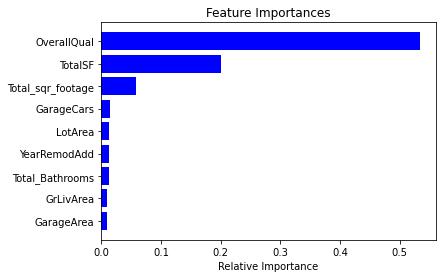

In [163]:
features = data.columns
importances = rand.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Model Training 

In [164]:
#Based on the above feature extraction the following features are selected to train the model
x = data[['OverallQual', 'TotalSF', 'Total_sqr_footage', 'GarageCars', 'LotArea', 'YearRemodAdd',
          'Total_Bathrooms', 'GrLivArea', 'GarageArea']]
y=data.iloc[:,-1]

In [165]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

Based on the data type, we picked Linear Regression, Random Forest and Support Vector Regressor to train the model

In [166]:
#Linear Regression

regressor = LinearRegression()
regressor.fit(x_train, np.log(y_train/100000))
y_pred=regressor.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred))

Mean Absolute Error: 0.10998326204626087
Mean Squared Error: 0.024124555763773665
Root Mean Squared Error: 0.15532081561649638
R-squared Error: 0.8577948651851072


In [167]:
#Random Forest Classifier

RandomForest = RandomForestRegressor(n_estimators=10)
RandomForest.fit(x_train, np.log(y_train/100000))
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_rand))

Mean Absolute Error: 0.10765823354891478
Mean Squared Error: 0.024454750088640752
Root Mean Squared Error: 0.15638014608204187
R-squared Error: 0.8558484944853678


In [168]:
#Support Vector Regressor

svr = SVR(kernel='rbf', gamma='scale')
svr.fit(x_train,np.log(y_train/100000))
y_pred_svr=svr.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_svr))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_svr))

Mean Absolute Error: 0.27950531469953943
Mean Squared Error: 0.1392583917663338
Root Mean Squared Error: 0.37317340709961344
R-squared Error: 0.17912443366215347


In [169]:
x.corr()

,OverallQual,TotalSF,Total_sqr_footage,GarageCars,LotArea,Total_Bathrooms,GrLivArea,GarageArea
OverallQual,1.000000,0.645718,0.500358,0.594523,0.183171,0.551807,0.564162,0.558972
TotalSF,0.645718,1.000000,0.783941,0.553540,0.413419,0.586854,0.829701,0.550053
Total_sqr_footage,0.500358,0.783941,1.000000,0.456556,0.390952,0.692099,0.727956,0.471606
GarageCars,0.594523,0.553540,0.456556,1.000000,0.276328,0.504248,0.477113,0.884389
LotArea,0.183171,0.413419,0.390952,0.276328,1.000000,0.228791,0.368696,0.287469
Total_Bathrooms,0.551807,0.586854,0.692099,0.504248,0.228791,1.000000,0.567636,0.476766
GrLivArea,0.564162,0.829701,0.727956,0.477113,0.368696,0.567636,1.000000,0.456441
GarageArea,0.558972,0.550053,0.471606,0.884389,0.287469,0.476766,0.456441,1.000000


From the above linear regression model, we can see that the acheived R-Squared error is 0.857 which is approx 93% accuracy same goes for random forest as well meanwhile support vector regressor performed worst. But looking at the correlation within the independent feature, it is noticed that there are some high correlation between independent features, hence here the model is overfitting which is not an optimal output.

#### So our next step would be remove the features with correlation and replace them with equally important feature based on its correlation with the output feature which is SalePrice

## <u>Model Improvement</u>

In [170]:
c=data.corr()

In [171]:
#Checking Correlation and isolating only the ones with correlation of 0.5 and above
print(c[c['SalePrice']>=0.5]['SalePrice'].sort_values())

TotRmsAbvGrd         0.524919
1stFlrSF             0.564648
TotalBsmtSF          0.594607
GarageArea           0.625770
GarageCars           0.640409
Total_Bathrooms      0.640882
GrLivArea            0.648993
Total_sqr_footage    0.668377
TotalSF              0.752735
OverallQual          0.790229
SalePrice            1.000000
Name: SalePrice, dtype: float64


<AxesSubplot:ylabel='None'>

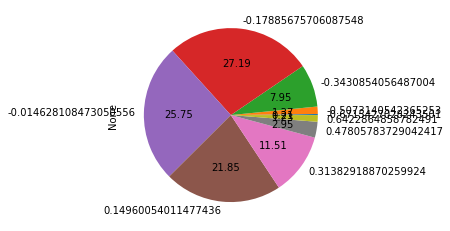

In [172]:
data.groupby('OverallQual').size().plot(kind='pie', autopct='%.2f')

The above pie chart gives an idea of value distribution of the OverallQual feature

Skewness: 0.22911695285853279
count    1460.000000
mean        0.443151
std         0.496928
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Foundation_PConc, dtype: float64


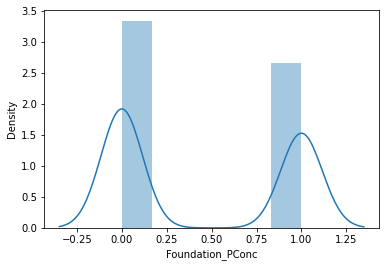

Skewness: 0.2789191948856172
count    1460.000000
mean        0.002807
std         0.224999
min        -0.671543
25%        -0.178857
50%        -0.014628
75%         0.149601
max         0.642286
Name: OverallQual, dtype: float64


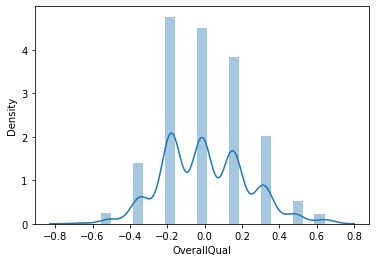

Skewness: 0.18693260445302762
count    1460.000000
mean       -0.008350
std         0.375233
min        -1.000000
25%        -0.243338
50%        -0.059581
75%         0.215937
max         1.215548
Name: TotalBsmtSF, dtype: float64


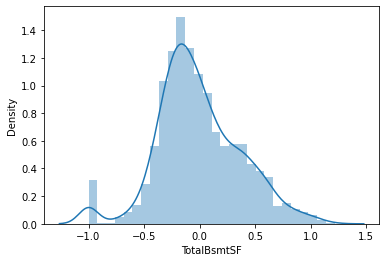

Skewness: 0.6321334404047088
count    1460.000000
mean       -0.009576
std         0.303462
min        -0.711965
25%        -0.239381
50%        -0.066905
75%         0.187713
max         0.948116
Name: 1stFlrSF, dtype: float64


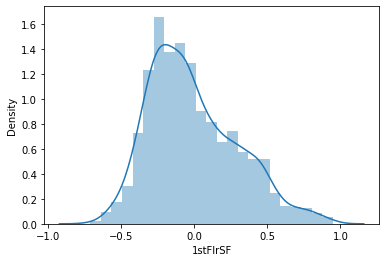

Skewness: 0.5715803715583723
count    1460.000000
mean       -0.008124
std         0.308836
min        -0.777446
25%        -0.247381
50%        -0.036821
75%         0.170907
max         0.984328
Name: GrLivArea, dtype: float64


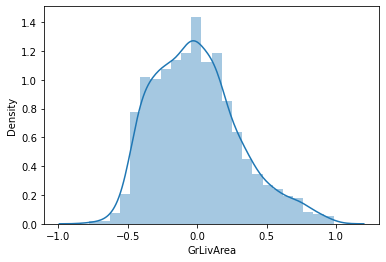

Skewness: 0.4732099685502003
count    1460.000000
mean        0.002418
std         0.238953
min        -0.689996
25%        -0.224989
50%        -0.069987
75%         0.085015
max         0.705023
Name: TotRmsAbvGrd, dtype: float64


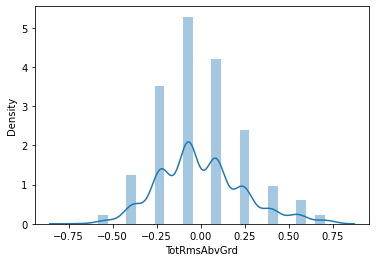

Skewness: -0.34254892974866585
count    1460.000000
mean        0.000433
std         0.423082
min        -1.000000
25%        -0.433863
50%         0.132273
75%         0.132273
max         1.264546
Name: GarageCars, dtype: float64


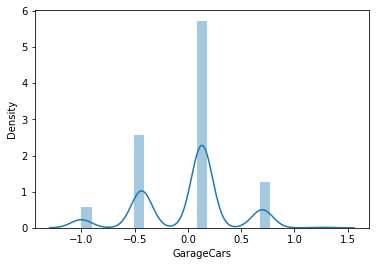

Skewness: -0.041740454468188415
count    1460.000000
mean       -0.007579
std         0.436349
min        -1.000000
25%        -0.292433
50%         0.015343
75%         0.218411
max         1.261253
Name: GarageArea, dtype: float64


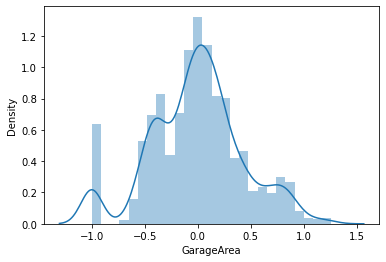

Skewness: 0.4367934298927637
count    1460.000000
mean       -0.005028
std         0.285262
min        -0.868903
25%        -0.211257
50%        -0.035021
75%         0.172812
max         0.934668
Name: TotalSF, dtype: float64


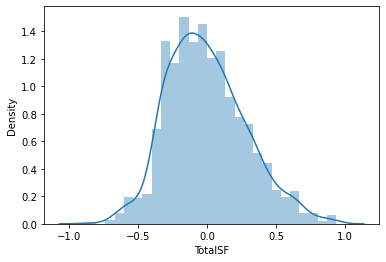

Skewness: 0.690437848705016
count    1460.000000
mean       -0.008279
std         0.343023
min        -0.831901
25%        -0.248590
50%        -0.066147
75%         0.188894
max         1.129919
Name: Total_sqr_footage, dtype: float64


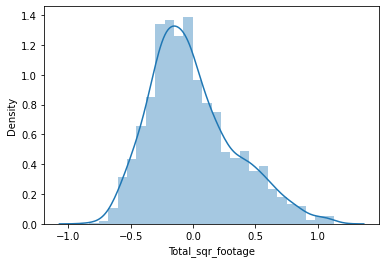

Skewness: 0.18134011421771032
count    1460.000000
mean       -0.005745
std         0.349641
min        -0.549259
25%        -0.098518
50%        -0.098518
75%         0.126853
max         1.028335
Name: Total_Bathrooms, dtype: float64


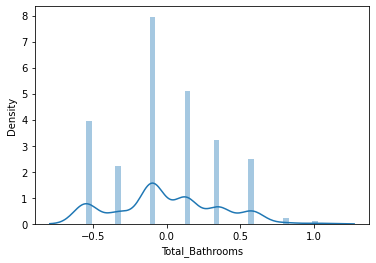

Skewness: 1.8828757597682129
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


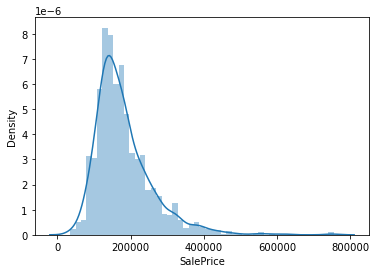

In [173]:
#Checking for skewness within the features with high correlation with SalePrice
high_corr_data = pd.DataFrame(c[c['SalePrice']>=0.49])
list(high_corr_data.index)
for selected_feat in list(high_corr_data.index):
    plt.tight_layout()
    sns.distplot(data[selected_feat])
    print("Skewness: "+str(data[selected_feat].skew()))
    print(data[selected_feat].describe())
    plt.show()

In [174]:
print(c[c['SalePrice']<=-0.49]['SalePrice'].sort_values())

ExterQual     -0.636884
BsmtQual      -0.593734
KitchenQual   -0.589189
age           -0.531832
Name: SalePrice, dtype: float64


### <i>The Idea is to select the features that have strong positive linear relationship with SalePrice and strong negative linear relationship with SalePrice and add the feature selected from feature importance technique</i>

In [175]:
# Selected feature from both the techniques
x = data[['Foundation_PConc','TotRmsAbvGrd', 'GarageArea', 
          'Total_Bathrooms','TotalBsmtSF', 'GarageCars', 'GrLivArea', 'LotArea',
          'Total_sqr_footage','OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

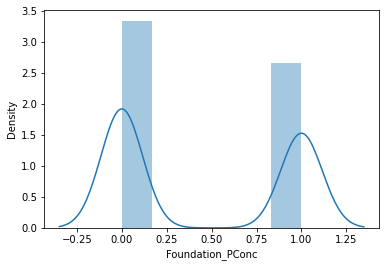

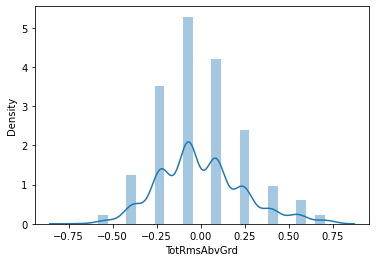

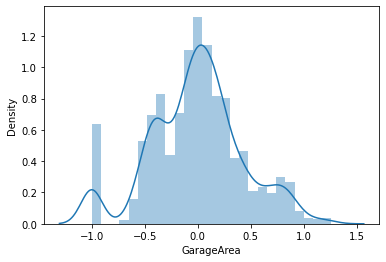

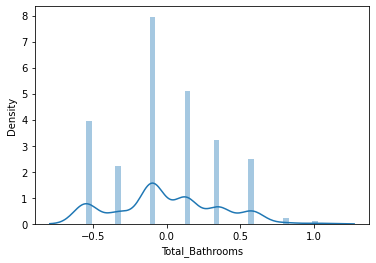

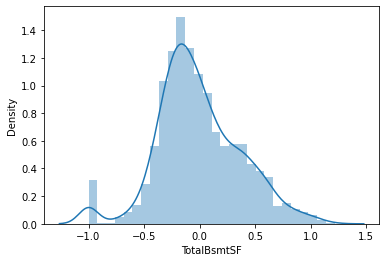

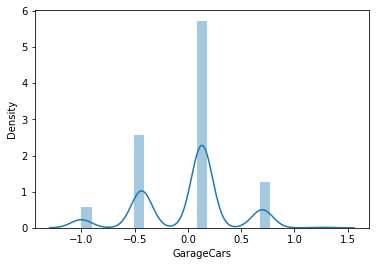

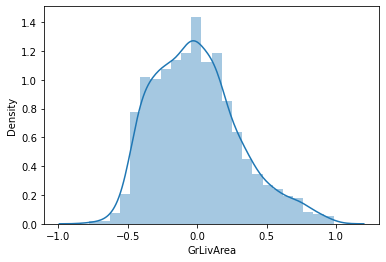

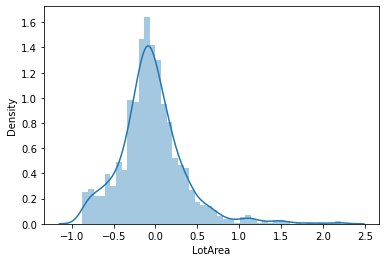

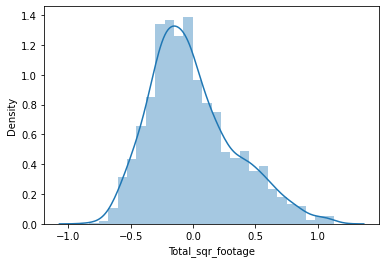

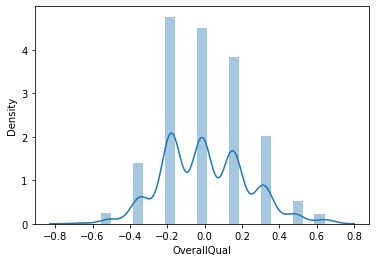

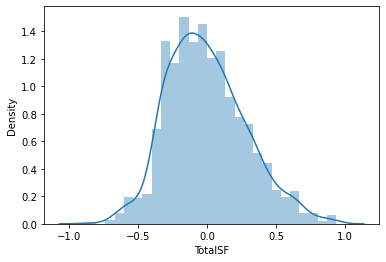

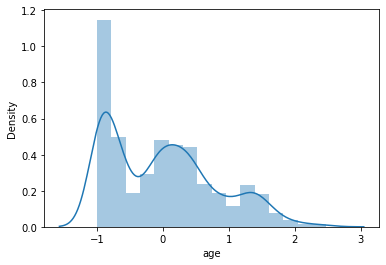

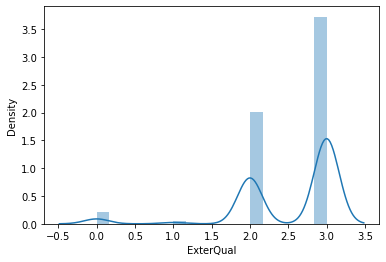

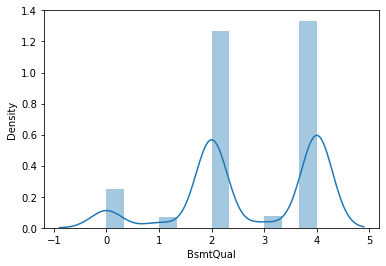

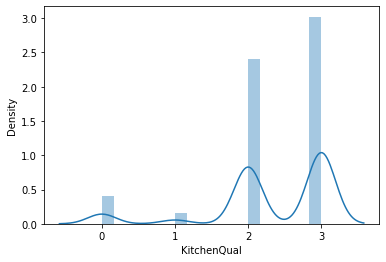

In [176]:
# Visualization of the data 
for col in x:
    plt.tight_layout()
    sns.distplot(data[col])
    plt.show()

From the visualization, we can notice that all the features are nearly symmetric

<AxesSubplot:>

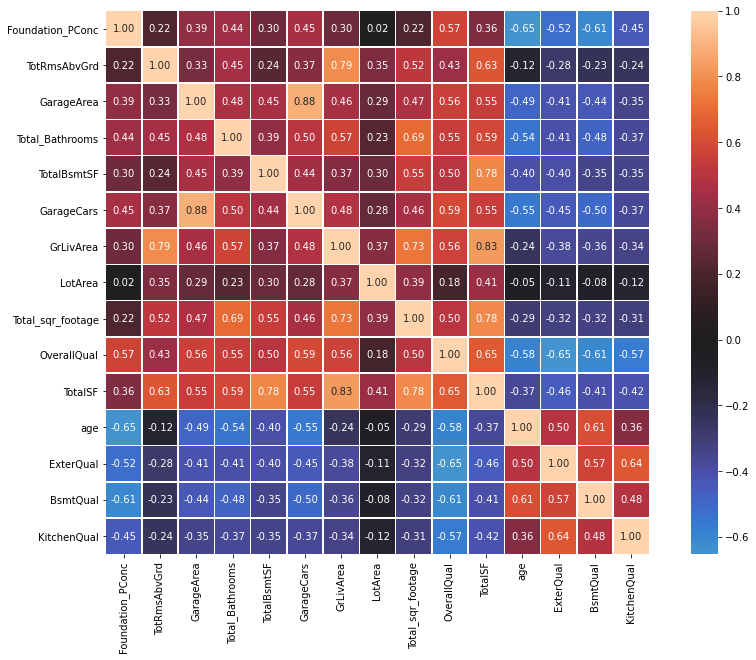

In [177]:
plt.figure(figsize=(15,10))
sns.heatmap(x.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True)
 #removing anything that has correlation of above 0.8

The above correlation plot gives a good visualization to identify the features that have high correlation. Through this plot it became easier to identify those features and remove from the selected features for model training

So from the heatmap, it is safe to say that GrLivArea has high correlation with TotRmsAbcGrd, GarageArea has high correlation with GarageCars, TotalSF has high correlation with TotalBsmtSF, TotalSF has high correlation with GrLivArea and TotalSF has high correlation with Total_sqr_footage.

So it would be safe for us to remove one feature from each pair, the following features are removed
<li>TotRmsAbvGrd</li>
<li>GarageCars</li>
<li>TotalBsmtSF</li>
<li>Total_sqr_footage</li>

In [178]:
#remove one from (GrLivArea, TotRmsAbvGrd), (GarageArea, GarageCars), (TotalSF, TotalBsmtSF)
# (TotalSF, GrLivArea), (TotalSF, Total_sqr_footage)
x = x.drop(columns=['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF', 'Total_sqr_footage'])

<AxesSubplot:>

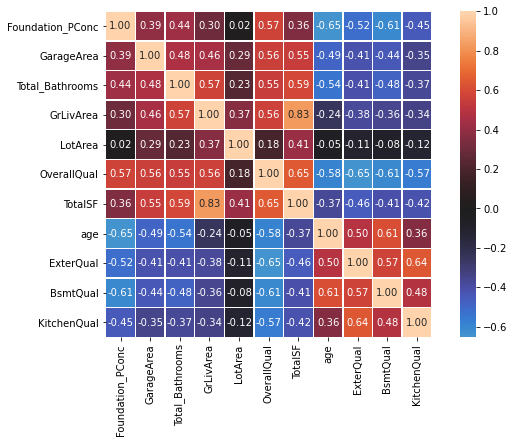

In [179]:
"""This plot gives a confirmation that there are no correlation within independent features and if there are, 
then they are removed in the next code block"""
plt.figure(figsize=(10,6))
sns.heatmap(x.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True)

In [180]:
x = x.drop(columns=['GrLivArea']) #remove ground living area
x.corr() #final confirmation

,Foundation_PConc,GarageArea,Total_Bathrooms,LotArea,OverallQual,TotalSF,age,ExterQual,BsmtQual,KitchenQual
Foundation_PConc,1.000000,0.393298,0.435338,0.016221,0.569124,0.356194,-0.652791,-0.515151,-0.611473,-0.449927
GarageArea,0.393298,1.000000,0.476766,0.287469,0.558972,0.550053,-0.489976,-0.414475,-0.437431,-0.345728
Total_Bathrooms,0.435338,0.476766,1.000000,0.228791,0.551807,0.586854,-0.537138,-0.407660,-0.483564,-0.365168
LotArea,0.016221,0.287469,0.228791,1.000000,0.183171,0.413419,-0.051416,-0.109175,-0.082175,-0.119716
OverallQual,0.569124,0.558972,0.551807,0.183171,1.000000,0.645718,-0.583959,-0.651419,-0.608147,-0.568675
TotalSF,0.356194,0.550053,0.586854,0.413419,0.645718,1.000000,-0.367843,-0.458340,-0.409856,-0.415505
age,-0.652791,-0.489976,-0.537138,-0.051416,-0.583959,-0.367843,1.000000,0.495865,0.608345,0.361189
ExterQual,-0.515151,-0.414475,-0.407660,-0.109175,-0.651419,-0.458340,0.495865,1.000000,0.572327,0.641584
BsmtQual,-0.611473,-0.437431,-0.483564,-0.082175,-0.608147,-0.409856,0.608345,0.572327,1.000000,0.484650
KitchenQual,-0.449927,-0.345728,-0.365168,-0.119716,-0.568675,-0.415505,0.361189,0.641584,0.484650,1.000000


In [181]:
x.head(10)

,Foundation_PConc,GarageArea,Total_Bathrooms,LotArea,OverallQual,TotalSF,age,ExterQual,BsmtQual,KitchenQual
Id,,,,,,,,,,
1,1,0.159183,0.577594,-0.168971,0.149601,0.007174,-0.863201,2,2,2
2,0,-0.026963,0.126853,-0.055872,-0.014628,-0.009312,-0.151843,3,2,3
3,1,0.286101,0.577594,0.106400,0.149601,0.062125,-0.808481,2,2,2
4,0,0.358021,-0.098518,-0.060789,0.149601,-0.029330,1.489751,3,4,2
5,1,0.768388,0.577594,0.402423,0.313829,0.312152,-0.781121,2,2,2
6,0,0.015343,0.126853,0.388163,-0.178857,-0.152969,-0.562242,3,2,3
7,1,0.345329,0.352224,-0.008272,0.313829,0.326674,-0.917920,2,0,2
8,0,0.023804,0.577594,0.021035,0.149601,0.254846,-0.015044,3,2,3
9,0,-0.010041,-0.098518,-0.398118,0.149601,0.069975,1.106712,3,4,3


### Model training with improved feature selection

In [182]:
model_1_acc = []
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=42)  

In [183]:
# Select features from test dataset for prediction
x_2=data2[['Foundation_PConc','GarageArea', 'Total_Bathrooms', 'LotArea',
           'OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

In [184]:
#Linear Regression

regressor = LinearRegression()
regressor.fit(x_train, np.log(y_train/100000))
y_pred=regressor.predict(x_test)
model_1_acc.append(['Linear Regression', metrics.r2_score(np.log(y_test/100000), y_pred)])
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred))

#Predit the sale price in test dataset and save as csv file for submissiom to kaggle competition
y_pred=regressor.predict(x_2)
print(y_pred)
my_submission = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred)})
my_submission.to_csv('reg_submission.csv', index=False)

Mean Absolute Error: 0.11073631181447191
Mean Squared Error: 0.024603111507661674
Root Mean Squared Error: 0.1568537902240863
R-squared Error: 0.8549739600151878
[0.22499386 0.45602147 0.52028228 ... 0.48253674 0.17170334 0.76880991]


In [185]:
#Support Vector Regressor

svr = SVR(kernel='rbf', gamma='scale')
svr.fit(x_train,np.log(y_train/100000))
y_pred_svr=svr.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_svr))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_svr))

model_1_acc.append(['Support Vector', metrics.r2_score(np.log(y_test/100000), y_pred_svr)])

Mean Absolute Error: 0.10587399635636117
Mean Squared Error: 0.024023451350392157
Root Mean Squared Error: 0.15499500427559643
R-squared Error: 0.858390837474756


In [186]:
#Decision Tree

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(x_train,np.log(y_train/100000))
y_pred_dt=dt.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_dt))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_dt)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_dt))

model_1_acc.append(['Decision Tree', metrics.r2_score(np.log(y_test/100000), y_pred_dt)])

Mean Absolute Error: 0.1277040151881427
Mean Squared Error: 0.03180535165192445
Root Mean Squared Error: 0.17834054965689786
R-squared Error: 0.8125194775072823


In [187]:
#Random Forest Classifier

RandomForest = RandomForestRegressor(n_estimators = 1000, min_samples_split=2, min_samples_leaf=1, 
                                     max_features= 'sqrt', max_depth=110, bootstrap=True)
RandomForest.fit(x_train, np.log(y_train/100000))
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_rand))

#Predit the sale price in test dataset and save as csv file for submissiom to kaggle competition
y_pred_rand_sub=RandomForest.predict(x_2)
print(y_pred_rand_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred_rand_sub)})
my_submission_rand.to_csv('rand_submission.csv', index=False)

model_1_acc.append(['Random Forest', metrics.r2_score(np.log(y_test/100000), y_pred_rand)])

Mean Absolute Error: 0.09753150465365115
Mean Squared Error: 0.02153177984598174
Root Mean Squared Error: 0.14673711134536396
R-squared Error: 0.8730782989007269
[0.19172943 0.5233777  0.5248115  ... 0.45371381 0.23527328 0.75203442]


In [188]:
#Optimizing Random Forest

#Original Parameters 
RandomForest.get_params()

#Random Search 
n_estimators = [int(x) for x in range(10,2001,10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in range(10,111,10)]
min_samples_split = [int(x) for x in range(2,20)]
min_samples_leaf = [int(x) for x in range(1,22)]
bootstrap = [True, False]

#Random Parameter Setting
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [189]:
#Baseline
rf_comparison = RandomForestRegressor()

#Random Parameters
rf_random = RandomizedSearchCV(estimator = rf_comparison, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

# Fit Random Parameter Model
rf_random.fit(x_train, np.log(y_train/100000))

# Print Best Parameters
print("Best Random Search Parameters: ", rf_random.best_params_)

#Baseline Comparison
rf_comparison.fit(x_train, np.log(y_train/100000))
y_pred_baseline=rf_comparison.predict(x_test)

#Create Optimized Model
best_random = rf_random.best_estimator_
best_random.fit(x_train, np.log(y_train/100000))
y_pred_rand=best_random.predict(x_test)

#Compare 
print("Original Model: ",metrics.r2_score(np.log(y_test/100000), y_pred_baseline))
print("Random Search Parameter Model: ",metrics.r2_score(np.log(y_test/100000), y_pred_rand))

model_1_acc.append(['Random Search Random Forest', metrics.r2_score(np.log(y_test/100000), y_pred_rand)])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Random Search Parameters:  {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Original Model:  0.8648068913636172
Random Search Parameter Model:  0.8696494879345693


In [190]:
# #Random Forest Classifier

# RandomForest = rf_random.best_estimator_
# RandomForest.fit(x_train, np.log(y_train/100000))
# y_pred_rand=RandomForest.predict(x_test)
# print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_rand))
# print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand)))
# print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_rand))
# y_pred_rand_sub=RandomForest.predict(x_2)
# print(y_pred_rand_sub)
# my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred_rand_sub)})
# my_submission_rand.to_csv('rand_submission.csv', index=False)

In [191]:
#Tune Random Search with Grid Search 

#Following Parameter Output from Random Parameter Search "Best"
parameter_gridSearch = {
    'bootstrap': [True],
    'max_depth': [int(x) for x in range(100,121,5)],
    'max_features': ['sqrt'],
    'min_samples_leaf': [int(x) for x in range(1,4)],
    'min_samples_split': [int(x) for x in range(1,4)],
    'n_estimators': [int(x) for x in range(200,1000,100)]
}

#Grid Search
grid_search = GridSearchCV(estimator = rf_comparison, param_grid = parameter_gridSearch, cv = 3, n_jobs = -1, verbose = 2)

#Search Grid for Best Parameters
grid_search.fit(x_train, np.log(y_train/100000))
print("Best Pareamters: ", grid_search.best_params_)

#Create Best Grid Parameter Model
best_random_grid = grid_search.best_estimator_
best_random_grid.fit(x_train, np.log(y_train/100000))
y_pred_rand=best_random_grid.predict(x_test)

#Compare
print("Original Model: ",metrics.r2_score(np.log(y_test/100000), y_pred_baseline))
print("Grid Search Parameter Model: ",metrics.r2_score(np.log(y_test/100000), y_pred_rand))


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Pareamters:  {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Original Model:  0.8648068913636172
Grid Search Parameter Model:  0.8732293484568011


In [192]:
#Random Forest Classifier

RandomForest = grid_search.best_estimator_
RandomForest.fit(x_train, np.log(y_train/100000))
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_rand))

model_1_acc.append(['Grid Search Random Forest', metrics.r2_score(np.log(y_test/100000), y_pred_rand)])

#Predit the sale price in test dataset and save as pdf for submissiom to kaggle competition
y_pred_rand_sub=RandomForest.predict(x_2)
print(y_pred_rand_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred_rand_sub)})
my_submission_rand.to_csv('rand_submission.csv', index=False)

Mean Absolute Error: 0.097752624741132
Mean Squared Error: 0.021610847016222203
Root Mean Squared Error: 0.14700628223386306
R-squared Error: 0.8726122278271877
[0.1960075  0.52904303 0.53171178 ... 0.4617232  0.24147877 0.74255305]


### The above feature improvement increased the R-Squared error by 0.02 approx, 

<i>Our Thoughts still remains around this one question - Can we do better?</i>


So we decided to go back to the beginning and change the features with high correlation to the once next in the list of feature importance

To fulfil our satisfaction, another approach
## Model Improvement Part 2

In [193]:
model_2_acc = []

# Selected based on the feature importance results
x1 = data[['OverallQual', 'TotalSF', 'Total_porch_sf', 'age', 'LotArea', 'YearRemodAdd',
          'Total_Bathrooms', 'Neighborhood_NoRidge', 'GarageArea']]

In [194]:
x1.corr()

,OverallQual,TotalSF,Total_porch_sf,age,LotArea,Total_Bathrooms,Neighborhood_NoRidge,GarageArea
OverallQual,1.000000,0.645718,0.314884,-0.583959,0.183171,0.551807,0.225968,0.558972
TotalSF,0.645718,1.000000,0.348257,-0.367843,0.413419,0.586854,0.220896,0.550053
Total_porch_sf,0.314884,0.348257,1.000000,-0.122565,0.215955,0.308144,0.155084,0.259398
age,-0.583959,-0.367843,-0.122565,1.000000,-0.051416,-0.537138,-0.136186,-0.489976
LotArea,0.183171,0.413419,0.215955,-0.051416,1.000000,0.228791,0.126389,0.287469
Total_Bathrooms,0.551807,0.586854,0.308144,-0.537138,0.228791,1.000000,0.227555,0.476766
Neighborhood_NoRidge,0.225968,0.220896,0.155084,-0.136186,0.126389,0.227555,1.000000,0.195165
GarageArea,0.558972,0.550053,0.259398,-0.489976,0.287469,0.476766,0.195165,1.000000


In [195]:
x_train, x_test, y_train, y_test = train_test_split(x1, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [196]:
x_2=data2[['OverallQual', 'TotalSF', 'Total_porch_sf', 'age', 'LotArea', 'YearRemodAdd',
          'Total_Bathrooms', 'Neighborhood_NoRidge', 'GarageArea']]

In [197]:
#Linear Regression

regressor = LinearRegression()
regressor.fit(x_train, np.log(y_train/100000))
y_pred=regressor.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred))

model_2_acc.append(['Linear Regression', metrics.r2_score(np.log(y_test/100000), y_pred)])

#Predit the sale price in test dataset and save as pdf for submissiom to kaggle competition
y_pred=regressor.predict(x_2)
print(y_pred)
my_submission = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred)})
my_submission.to_csv('reg_submission.csv', index=False)

Mean Absolute Error: 0.1067490549244727
Mean Squared Error: 0.0230406405771355
Root Mean Squared Error: 0.15179143775962958
R-squared Error: 0.8641841353856905
[0.229945   0.44018455 0.5403854  ... 0.56953053 0.18044787 0.78019706]


In [198]:
#Random Forest Classifier

RandomForest = RandomForestRegressor()
RandomForest.fit(x_train, y_train/100000)
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred_rand)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred_rand))


model_2_acc.append(['Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

#Predit the sale price in test dataset and save as pdf for submissiom to kaggle competition
y_pred_rand_sub=RandomForest.predict(x_2)
print(y_pred_rand_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*y_pred_rand_sub})
my_submission_rand.to_csv('rand1_submission.csv', index=False)

Mean Absolute Error: 0.17876400390302244
Mean Squared Error: 0.0791240102630567
Root Mean Squared Error: 0.28128990430347245
R-squared Error: 0.8866108525139593
[1.22584   1.7343827 1.8342955 ... 1.84397   1.1917475 2.18168  ]


In [199]:
#Optimizing Random Forest

#Original Parameters 
RandomForest.get_params()

#Random Search 
n_estimators = [int(x) for x in range(10,2001,10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in range(1,111,10)]
min_samples_split = [int(x) for x in range(2,20)]
min_samples_leaf = [int(x) for x in range(1,22)]
bootstrap = [True, False]

#Random Parameter Setting
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [200]:
#Baseline
rf_comparison = RandomForestRegressor()

#Random Parameters
rf_random = RandomizedSearchCV(estimator = rf_comparison, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit Random Parameter Model
rf_random.fit(x_train, y_train/100000)

# Print Best Parameters
print("Best Random Search Parameters: ", rf_random.best_params_)

#Baseline Comparison
rf_comparison.fit(x_train, y_train/100000)
y_pred_baseline=rf_comparison.predict(x_test)

#Create Optimized Model
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train/100000)
y_pred_rand=best_random.predict(x_test)

model_2_acc.append(['Random Search Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

#Compare 
print("Original Model: ",metrics.r2_score(y_test/100000, y_pred_baseline))
print("Random Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Random Search Parameters:  {'n_estimators': 480, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 101, 'bootstrap': False}
Original Model:  0.8920245452414906
Random Search Parameter Model:  0.8907708209300562


In [201]:
#Tune Random Search with Grid Search 

#Following Parameter Output from Random Parameter Search "Best"
parameter_gridSearch = {
    'bootstrap': [True,False],
    'max_depth': [int(x) for x in range(10,100,10)],
    'max_features': ['sqrt'],
    'min_samples_leaf': [int(x) for x in range(1,4)],
    'min_samples_split': [int(x) for x in range(1,4)],
    'n_estimators': [int(x) for x in range(50,500,50)]
}

#Grid Search
grid_search = GridSearchCV(estimator = rf_comparison, param_grid = parameter_gridSearch, 
                           cv = 3, n_jobs = -1, verbose = 2)

#Search Grid for Best Parameters
grid_search.fit(x_train, y_train/100000)
print("Best Pareamters: ", grid_search.best_params_)

#Create Best Grid Parameter Model
best_random_grid = grid_search.best_estimator_
best_random_grid.fit(x_train, y_train/100000)
y_pred_rand_grid=best_random_grid.predict(x_test)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
Best Pareamters:  {'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [202]:
#Compare
print("Original Model: ",metrics.r2_score(y_test/100000, y_pred_baseline))
print("Grid Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand_grid))
print("Random Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand))

Original Model:  0.8920245452414906
Grid Search Parameter Model:  0.8917577514816023
Random Search Parameter Model:  0.8907708209300562


In [203]:
#Random Forest Classifier

RandomForest = grid_search.best_estimator_
RandomForest.fit(x_train, y_train/100000)
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred_rand)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred_rand))

model_2_acc.append(['Grid Search Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

#Predit the sale price in test dataset and save as pdf for submissiom to kaggle competition
y_pred_rand_sub=RandomForest.predict(x_2)
print(y_pred_rand_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*y_pred_rand_sub})
my_submission_rand.to_csv('rand2_submission.csv', index=False)

Mean Absolute Error: 0.1812265904109588
Mean Squared Error: 0.07698300259351089
Root Mean Squared Error: 0.2774581096192917
R-squared Error: 0.8896790366669587
[1.280085   1.63073603 1.84510833 ... 1.72334417 1.23879167 2.2190592 ]


In [204]:
#Decision Tree

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(x_train,y_train/100000)
y_pred_dt=dt.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred_dt))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred_dt)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred_dt))

model_2_acc.append(['Decision Tree', metrics.r2_score(y_test/100000, y_pred_dt)])

Mean Absolute Error: 0.23072484562091583
Mean Squared Error: 0.11977257331850678
Root Mean Squared Error: 0.34608174369432837
R-squared Error: 0.8283591802836646


### Atlast we managed to fulfil our desire and increased the R-squared error value to another 0.02, now the highest recorded is 0.892

In [205]:
model_3_acc = []

my_submission_rand

,Id,SalePrice
0,1461,128008.500000
1,1462,163073.603333
2,1463,184510.833333
3,1464,188780.106667
4,1465,191237.756667
...,...,...
1454,2915,87813.666667
1455,2916,89586.333333
1456,2917,172334.416667
1457,2918,123879.166667


### <u>One final approach</u>

Merge all resulting features and train the model

In [206]:
x_3 = data[['OverallQual', 'TotalSF', 'Total_porch_sf', 'age', 'LotArea', 'YearRemodAdd',
          'Total_Bathrooms', 'Neighborhood_NoRidge', 'GarageArea','Foundation_PConc', 'GarageArea', 
          'LotArea','OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

In [207]:
x_3.corr()

,OverallQual,TotalSF,Total_porch_sf,age,LotArea,Total_Bathrooms,Neighborhood_NoRidge,GarageArea,Foundation_PConc,GarageArea,LotArea,OverallQual,TotalSF,age,ExterQual,BsmtQual,KitchenQual
OverallQual,1.000000,0.645718,0.314884,-0.583959,0.183171,0.551807,0.225968,0.558972,0.569124,0.558972,0.183171,1.000000,0.645718,-0.583959,-0.651419,-0.608147,-0.568675
TotalSF,0.645718,1.000000,0.348257,-0.367843,0.413419,0.586854,0.220896,0.550053,0.356194,0.550053,0.413419,0.645718,1.000000,-0.367843,-0.458340,-0.409856,-0.415505
Total_porch_sf,0.314884,0.348257,1.000000,-0.122565,0.215955,0.308144,0.155084,0.259398,0.173566,0.259398,0.215955,0.314884,0.348257,-0.122565,-0.229524,-0.231585,-0.224316
age,-0.583959,-0.367843,-0.122565,1.000000,-0.051416,-0.537138,-0.136186,-0.489976,-0.652791,-0.489976,-0.051416,-0.583959,-0.367843,1.000000,0.495865,0.608345,0.361189
LotArea,0.183171,0.413419,0.215955,-0.051416,1.000000,0.228791,0.126389,0.287469,0.016221,0.287469,1.000000,0.183171,0.413419,-0.051416,-0.109175,-0.082175,-0.119716
Total_Bathrooms,0.551807,0.586854,0.308144,-0.537138,0.228791,1.000000,0.227555,0.476766,0.435338,0.476766,0.228791,0.551807,0.586854,-0.537138,-0.407660,-0.483564,-0.365168
Neighborhood_NoRidge,0.225968,0.220896,0.155084,-0.136186,0.126389,0.227555,1.000000,0.195165,0.182197,0.195165,0.126389,0.225968,0.220896,-0.136186,-0.156145,-0.135292,-0.099560
GarageArea,0.558972,0.550053,0.259398,-0.489976,0.287469,0.476766,0.195165,1.000000,0.393298,1.000000,0.287469,0.558972,0.550053,-0.489976,-0.414475,-0.437431,-0.345728
Foundation_PConc,0.569124,0.356194,0.173566,-0.652791,0.016221,0.435338,0.182197,0.393298,1.000000,0.393298,0.016221,0.569124,0.356194,-0.652791,-0.515151,-0.611473,-0.449927
GarageArea,0.558972,0.550053,0.259398,-0.489976,0.287469,0.476766,0.195165,1.000000,0.393298,1.000000,0.287469,0.558972,0.550053,-0.489976,-0.414475,-0.437431,-0.345728


In [208]:
x_train, x_test, y_train, y_test = train_test_split(x_3, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [209]:
x_4 = data2[['OverallQual', 'TotalSF', 'Total_porch_sf', 'age', 'LotArea', 'YearRemodAdd',
          'Total_Bathrooms', 'Neighborhood_NoRidge', 'GarageArea','Foundation_PConc', 'GarageArea', 
          'LotArea','OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

In [210]:
#Random Forest Classifier

RandomForest = RandomForestRegressor()
RandomForest.fit(x_train, y_train/100000)
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred_rand)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred_rand))

model_3_acc.append(['Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

y_pred_rand_sub=RandomForest.predict(x_4)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*y_pred_rand_sub})
my_submission_rand.to_csv('rand3_submission.csv', index=False)

Mean Absolute Error: 0.17911078862796262
Mean Squared Error: 0.07737200882856884
Root Mean Squared Error: 0.2781582442218257
R-squared Error: 0.8891215688994211


In [211]:
#Optimizing Random Forest
rf_comparison = RandomForestRegressor() 
#Random Search 
n_estimators = [int(x) for x in range(10,2001,10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in range(1,150,10)]
min_samples_split = [int(x) for x in range(2,22)]
min_samples_leaf = [int(x) for x in range(1,22)]
bootstrap = [True, False]

#Random Parameter Setting
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Baseline Original Parameters 
rf_comparison = RandomForestRegressor()
print(rf_comparison.get_params())

#Random Parameters
rf_random = RandomizedSearchCV(estimator = rf_comparison, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit Random Parameter Model
rf_random.fit(x_train, y_train/100000)

# Print Best Parameters
print("Best Random Search Parameters: ", rf_random.best_params_)

#Baseline Comparison
rf_comparison.fit(x_train, y_train/100000)
y_pred_baseline=rf_comparison.predict(x_test)

#Create Optimized Model
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train/100000)
y_pred_rand=best_random.predict(x_test)

#Compare 
print("Original Model: ",metrics.r2_score(y_test/100000, y_pred_baseline))
print("Random Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand))
model_3_acc.append(['Random Search Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Random Search Parameters:  {'n_estimators': 490, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 131, 'bootstrap': False}
Original Model:  0.8924685997308918
Random Search Parameter Model:  0.8710390992425269


In [212]:
#Tune Random Search with Grid Search 

#Following Parameter Output from Random Parameter Search "Best"
parameter_gridSearch = {
    'bootstrap': [True,False],
    'max_depth': [int(x) for x in range(10,121,10)],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [int(x) for x in range(1,4)],
    'min_samples_split': [int(x) for x in range(1,4)],
    'n_estimators': [int(x) for x in range(50,500,50)]
}

#Grid Search
grid_search = GridSearchCV(estimator = rf_comparison, param_grid = parameter_gridSearch, 
                           cv = 3, n_jobs = -1, verbose = 2)

#Search Grid for Best Parameters
grid_search.fit(x_train, y_train/100000)
print("Best Pareamters: ", grid_search.best_params_)

#Create Best Grid Parameter Model
best_random_grid = grid_search.best_estimator_
best_random_grid.fit(x_train, y_train/100000)
y_pred_rand_grid=best_random_grid.predict(x_test)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
Best Pareamters:  {'bootstrap': False, 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [213]:
#Compare
print("Original Model: ",metrics.r2_score(y_test/100000, y_pred_baseline))
print("Random Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand))
print("Grid Search Parameter Model: ",metrics.r2_score(y_test/100000, y_pred_rand_grid))

Original Model:  0.8924685997308918
Random Search Parameter Model:  0.8710390992425269
Grid Search Parameter Model:  0.8935643792644647


In [214]:
#Random Forest Classifier
RandomForest = grid_search.best_estimator_
RandomForest.fit(x_train, y_train/100000)
y_pred_rand_grid=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred_rand_grid))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred_rand_grid))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred_rand_grid)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred_rand_grid))

model_3_acc.append(['Grid Search Random Forest', metrics.r2_score(y_test/100000, y_pred_rand)])

#Predit the sale price in test dataset and save as pdf for submissiom to kaggle competition
y_pred_rand_grid_sub=RandomForest.predict(x_4)
print(y_pred_rand_grid_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*y_pred_rand_grid_sub})
my_submission_rand.to_csv('rand4_submission.csv', index=False)

Mean Absolute Error: 0.1782774872146119
Mean Squared Error: 0.07521776458519114
Root Mean Squared Error: 0.2742585724917111
R-squared Error: 0.892208721805615
[1.23698  1.650058 1.73426  ... 1.66171  1.24378  2.1751  ]


#### <u>End of Model training and improvement</u>

## <u>Result Visualization</u>

<Figure size 1080x720 with 0 Axes>

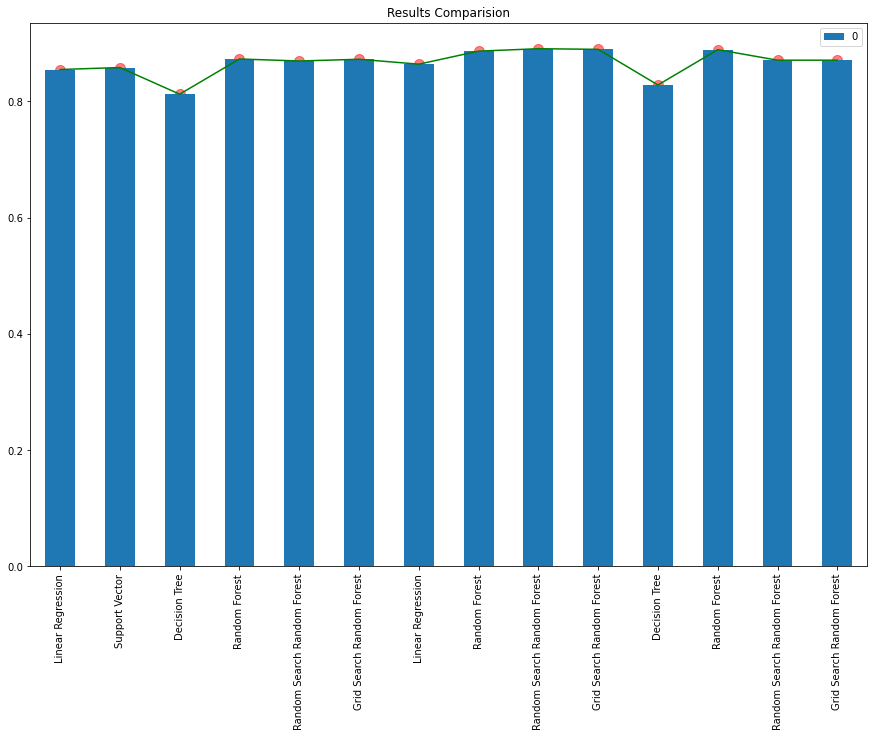

<Figure size 1080x720 with 0 Axes>

In [263]:
#super_model = model_1_acc+[('',0),('',0),('',0)]+model_2_acc+[('',0),('',0),('',0)]+model_3_acc
super_model = model_1_acc+model_2_acc+model_3_acc
models, results = zip(*super_model);

index = np.arange(len(models))

"""plt.bar(index, results, align='center')
plt.xticks(index, models,rotation=-45)"""

df.plot(kind='bar',figsize=(15,10), title="Results Comparision")
plt.scatter(index, results, color= 'r', marker='o', alpha=0.5, s=100)
plt.plot(index, results, color= 'g')
plt.figure(figsize=(15, 10))

The above bar graph gives a visual on which algorithm performs well on different model improvement method. As it is evident from the bar graph, <b>Random Forest</b> outperformed all other ML algorithms and gave the best R-squared value.

<i>The above bar graph also gives a visual of how models are improved by performing various feature improvement technique</i>

Random Forest Regressor is considered to be the best model of this type of problem because, it trys to limit overfitting while training the model, it is an ensemble technique where the model performs multiple Decision Tree model on sub-dataset(Grouping the dataset in to small dicsrete datasets) and takes the average predicted SalePrice from each of the sub-model prediction as the final predicted SalePrice.